In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(u"datos_limpios/2014.csv")

In [2]:
sub_df = df[["GEN_ALU",
               'cat_periodo',
               'anio_ing_carr_ori',
               'anio_ing_carr_act',
               "rango_edad", 
               "tipo_inst_3", 
               "jornada", 
               "tipo_plan_carr", 
               "dur_estudio_carr", 
               "nivel_carrera_1", 
               "nivel_global", 
               "valor_matricula", 
               "valor_arancel", 
               "oecd_area", 
               "acreditada_carr", 
               "acreditada_inst"]]

sub_df = (sub_df.query("nivel_global=='Pregrado' or nivel_global.isnull()")
                 .drop(columns = ['nivel_global'])
                 .dropna(subset=['anio_ing_carr_act']))

sub_df['anio_en_carr_actual'] = sub_df['anio_ing_carr_act'] - sub_df['cat_periodo']

# se pide que cat_periodo == anio_ing_carr_act para no contar a una misma persona todos los años
sub_df['Class'] = sub_df.apply(lambda row: row.cat_periodo != row.anio_ing_carr_ori and row.cat_periodo == row.anio_ing_carr_act, axis = 1)
sub_df = sub_df.drop(columns = ['anio_ing_carr_ori', 'cat_periodo', 'anio_ing_carr_act'])

sub_df['acreditada_carr'] = sub_df['acreditada_carr'].replace('NO ACREDITADA', False, regex=True)
sub_df['acreditada_carr'] = sub_df['acreditada_carr'].replace('ACREDITADA', True, regex=True)
sub_df['acreditada_inst'] = sub_df['acreditada_inst'].replace('NO ACREDITADA', False, regex=True)
sub_df['acreditada_inst'] = sub_df['acreditada_inst'].replace('ACREDITADA', True, regex=True)

In [3]:
# Se obtienen los tipos de cada columa en un dataframe
df_sub_datatypes = (pd.DataFrame(sub_df.dtypes)
                    .reset_index()
                    .rename(columns = {0:'tipo', 'index' : 'columna'})
                    )

# para cada columna...
cols_name = list(sub_df).remove('GEN_ALU')
df_sub_one_hot = pd.get_dummies(sub_df[['GEN_ALU']], prefix='GEN_ALU')
for i in range(1, len(df_sub_datatypes)):
    col_name = df_sub_datatypes.iloc[i][0]
    
    # Si es que es de tipo object...
    if str(df_sub_datatypes.iloc[i][1]) == 'object':
        # se le aplica la transformación One Hot
        df_one_hot = pd.get_dummies(sub_df[[col_name]], prefix=col_name)
    else:
        df_one_hot = sub_df[[col_name]]
    df_sub_one_hot = pd.merge(df_sub_one_hot, df_one_hot, left_index=True, right_index=True)

df_sub_one_hot

,GEN_ALU,rango_edad_15 a 19 años,rango_edad_20 a 24 años,rango_edad_25 a 29 años,rango_edad_30 a 34 años,rango_edad_35 a 39 años,rango_edad_40 y más años,tipo_inst_3_Centros de Formación Técnica,tipo_inst_3_Institutos Profesionales,tipo_inst_3_Universidades Estatales CRUCH,...,oecd_area_Educación,oecd_area_Humanidades y Artes,"oecd_area_Ingeniería, Industria y Construcción",oecd_area_Salud y Servicios Sociales,oecd_area_Servicios,oecd_area_Sin área definida,acreditada_carr,acreditada_inst,anio_en_carr_actual,Class
1177,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,False,False,0.0,False
1215,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,False,False,0.0,False
1220,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,True,True,-1.0,False
1230,2,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,True,True,-1.0,False
1231,2,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,False,True,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215062,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,False,False,-1.0,False
1215082,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,False,False,-1.0,False
1215085,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,False,False,-1.0,False
1215093,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,False,False,-1.0,False


<AxesSubplot:>

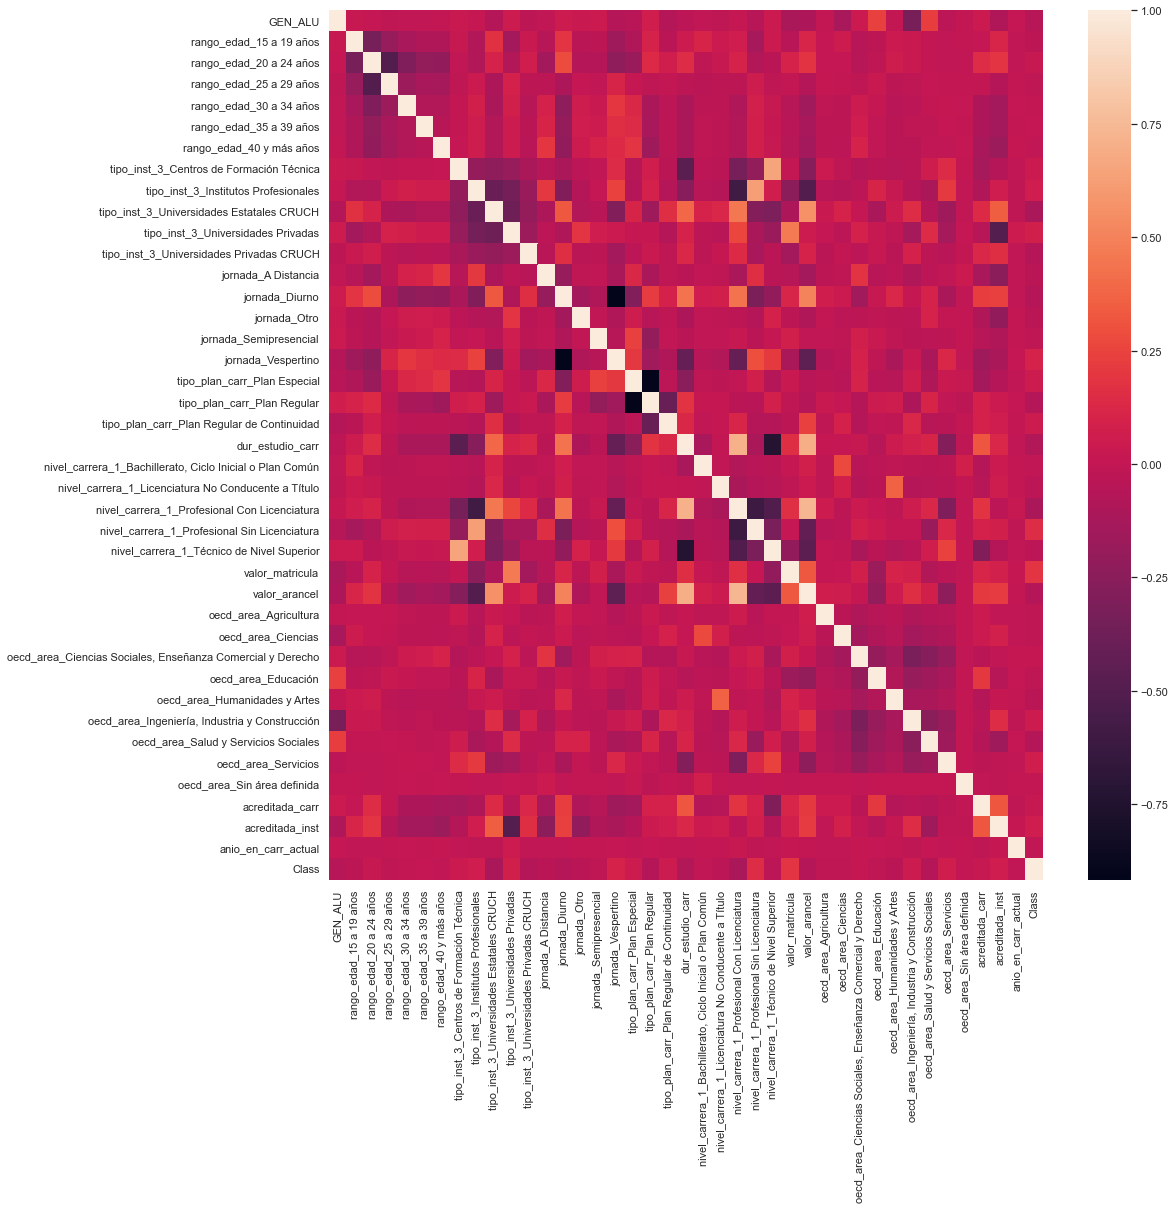

In [4]:
import seaborn

corr_sub = df_sub_one_hot.corr()
seaborn.set(rc={'figure.figsize':(16,16)})
seaborn.heatmap(corr_sub)

In [5]:
df_sub_one_hot = df_sub_one_hot.drop(columns = ['tipo_plan_carr_Plan Regular','valor_matricula', 'valor_arancel'])

In [6]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import numpy as np

data_train, data_test, ytrain, ytest = train_test_split(df_sub_one_hot, df_sub_one_hot['Class'], test_size=0.3, stratify=df_sub_one_hot['Class'])
diferencia = ytrain.value_counts()[False]-ytrain.value_counts()[True]
data_train = data_train.reset_index(drop=True)

# oversampling sobre la clase True
idx = np.random.choice(data_train[data_train['Class'] == True].index, size=diferencia)
data_oversampled = pd.concat([data_train, data_train.iloc[idx]])
print("Data oversampled on class 'True'")
print(data_oversampled['Class'].value_counts())

# subsampling sobre la clase False
idx = np.random.choice(data_train.loc[data_train.Class == False].index, size=diferencia, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
print("Data subsampled on class 'False'")
print(data_subsampled['Class'].value_counts())

Data oversampled on class 'True'
True     138643
False    138643
Name: Class, dtype: int64
Data subsampled on class 'False'
True     16488
False    16488
Name: Class, dtype: int64


In [7]:
from sklearn.metrics import classification_report

# datos test (mismo para todos los conjuntos de entrenamiento)
X_test = data_test[data_train.columns[:-1]]
y_test = data_test[data_train.columns[-1]]

# datos entrenamiento "originales"
X_orig = data_train[data_train.columns[:-1]] 
y_orig = data_train[data_train.columns[-1]] 

# datos entrenamiento "oversampleados" 
X_over = data_oversampled[data_train.columns[:-1]]
y_over = data_oversampled[data_train.columns[-1]]

# datos entrenamiento "subsampleados"
X_subs = data_subsampled[data_train.columns[:-1]]
y_subs = data_subsampled[data_train.columns[-1]]

In [8]:
from sklearn.tree import DecisionTreeClassifier

print("ORIGINAL::::::::::")
clf_orig = DecisionTreeClassifier()
clf_orig.fit(X_orig, y_orig)
pred_orig = clf_orig.predict(X_test)
print(classification_report(y_test, pred_orig))

print("OVERSAMPLING::::::::::")
clf_over = DecisionTreeClassifier()
clf_over.fit(X_over, y_over)
pred_over = clf_over.predict(X_test)
print(classification_report(y_test, pred_over))

print("SUBSAMPLING::::::::::")
clf_subs = DecisionTreeClassifier()
clf_subs.fit(X_subs, y_subs)
pred_subs = clf_subs.predict(X_test)
print(classification_report(y_test, pred_subs))

ORIGINAL::::::::::
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     59419
        True       0.95      0.86      0.91      7067

    accuracy                           0.98     66486
   macro avg       0.97      0.93      0.95     66486
weighted avg       0.98      0.98      0.98     66486

OVERSAMPLING::::::::::
              precision    recall  f1-score   support

       False       1.00      0.96      0.98     59419
        True       0.73      0.96      0.83      7067

    accuracy                           0.96     66486
   macro avg       0.86      0.96      0.90     66486
weighted avg       0.97      0.96      0.96     66486

SUBSAMPLING::::::::::
              precision    recall  f1-score   support

       False       0.99      0.96      0.98     59419
        True       0.73      0.96      0.83      7067

    accuracy                           0.96     66486
   macro avg       0.86      0.96      0.90     66486
weighted a

In [9]:
from sklearn.naive_bayes import GaussianNB  # Naive bayes

print("ORIGINAL::::::::::")
clf_orig = GaussianNB()
clf_orig.fit(X_orig, y_orig)
pred_orig = clf_orig.predict(X_test)
print(classification_report(y_test, pred_orig))

print("OVERSAMPLING::::::::::")
clf_over = GaussianNB()
clf_over.fit(X_over, y_over)
pred_over = clf_over.predict(X_test)
print(classification_report(y_test, pred_over))

print("SUBSAMPLING::::::::::")
clf_subs = GaussianNB()
clf_subs.fit(X_subs, y_subs)
pred_subs = clf_subs.predict(X_test)
print(classification_report(y_test, pred_subs))

ORIGINAL::::::::::
              precision    recall  f1-score   support

       False       1.00      0.81      0.89     59419
        True       0.38      0.97      0.55      7067

    accuracy                           0.83     66486
   macro avg       0.69      0.89      0.72     66486
weighted avg       0.93      0.83      0.86     66486

OVERSAMPLING::::::::::
              precision    recall  f1-score   support

       False       1.00      0.80      0.89     59419
        True       0.37      0.98      0.54      7067

    accuracy                           0.82     66486
   macro avg       0.69      0.89      0.72     66486
weighted avg       0.93      0.82      0.85     66486

SUBSAMPLING::::::::::
              precision    recall  f1-score   support

       False       1.00      0.80      0.89     59419
        True       0.37      0.98      0.54      7067

    accuracy                           0.82     66486
   macro avg       0.69      0.89      0.72     66486
weighted a

In [10]:
from sklearn.neighbors import KNeighborsClassifier

print("ORIGINAL::::::::::")
clf_orig = KNeighborsClassifier()
clf_orig.fit(X_orig, y_orig)
pred_orig = clf_orig.predict(X_test)
print(classification_report(y_test, pred_orig))

print("OVERSAMPLING::::::::::")
clf_over = KNeighborsClassifier()
clf_over.fit(X_over, y_over)
pred_over = clf_over.predict(X_test)
print(classification_report(y_test, pred_over))

print("SUBSAMPLING::::::::::")
clf_subs = KNeighborsClassifier()
clf_subs.fit(X_subs, y_subs)
pred_subs = clf_subs.predict(X_test)
print(classification_report(y_test, pred_subs))

ORIGINAL::::::::::
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     59419
        True       0.93      0.84      0.88      7067

    accuracy                           0.98     66486
   macro avg       0.95      0.92      0.93     66486
weighted avg       0.98      0.98      0.98     66486

OVERSAMPLING::::::::::
              precision    recall  f1-score   support

       False       0.99      0.95      0.97     59419
        True       0.69      0.95      0.80      7067

    accuracy                           0.95     66486
   macro avg       0.84      0.95      0.89     66486
weighted avg       0.96      0.95      0.95     66486

SUBSAMPLING::::::::::
              precision    recall  f1-score   support

       False       0.99      0.92      0.96     59419
        True       0.59      0.95      0.73      7067

    accuracy                           0.93     66486
   macro avg       0.79      0.94      0.84     66486
weighted a

In [11]:
from sklearn.svm import SVC  # Support Vector Machine classifier

print("ORIGINAL::::::::::")
clf_orig = SVC()
clf_orig.fit(X_orig, y_orig)
pred_orig = clf_orig.predict(X_test)
print(classification_report(y_test, pred_orig))

print("OVERSAMPLING::::::::::")
clf_over = SVC()
clf_over.fit(X_over, y_over)
pred_over = clf_over.predict(X_test)
print(classification_report(y_test, pred_over))

print("SUBSAMPLING::::::::::")
clf_subs = SVC()
clf_subs.fit(X_subs, y_subs)
pred_subs = clf_subs.predict(X_test)
print(classification_report(y_test, pred_subs))

ORIGINAL::::::::::


C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.89      1.00      0.94     59419
        True       0.00      0.00      0.00      7067

    accuracy                           0.89     66486
   macro avg       0.45      0.50      0.47     66486
weighted avg       0.80      0.89      0.84     66486

OVERSAMPLING::::::::::


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv(u"datos_limpios/2014.csv")